In [21]:
from datetime import datetime, timedelta
import torch
from earth2studio.data import GEFS_FX, HRRR, GEFS_FX_721x1440
import os
import io
import tarfile
from pathlib import Path
import numpy as np
import requests
import tqdm


# Inputs 
GEFS_SELECT_VARIABLES = [
    "u10m", 
    "v10m",
    "t2m",
    "r2m",
    "sp",
    "msl",
    "tcwv",
]

GEFS_VARIABLES = [
    "u1000",
    "u925",
    "u850",
    "u700",
    "u500",
    "u250",
    "v1000",
    "v925",
    "v850",
    "v700",
    "v500",
    "v250",
    "z1000",
    "z925",
    "z850",
    "z700",
    "z500",
    "z200",
    "t1000",
    "t925",
    "t850",
    "t700",
    "t500",
    "t100",
    "r1000",
    "r925",
    "r850",
    "r700",
    "r500",
    "r100",
]

ds_gefs = GEFS_FX(cache=True)
ds_gefs_select = GEFS_FX_721x1440(cache=True, member="gec00")

# Function that processes the input 

def fetch_input_gefs(
    time: datetime, lead_time: timedelta, content_dtype: str = "float32"
):
    """Fetch input GEFS data and place into a single numpy array

    Parameters
    ----------
    time : datetime
        Time stamp to fetch
    lead_time : timedelta
        Lead time to fetch
    filename : str
        File name to save input array to
    content_dtype : str
        Numpy dtype to save numpy
    """
    dtype = np.dtype(getattr(np, content_dtype))
    
    # Fetch high-res select GEFS input data
    select_data = ds_gefs_select(time, lead_time, GEFS_SELECT_VARIABLES)
    select_data = select_data.values
    # Crop to bounding box [225, 21, 300, 53]
    select_data = select_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert select_data.shape == (1, len(GEFS_SELECT_VARIABLES), 129, 301)

    # Fetch GEFS input data
    pressure_data = ds_gefs(time, lead_time, GEFS_VARIABLES)
    
    # Interpolate to 0.25 grid to tensor using nearest neighbor interpolation
    pressure_data = torch.nn.functional.interpolate(
        torch.Tensor(pressure_data.values),
        (len(GEFS_VARIABLES), 721, 1440),
        mode="nearest",
    )
    #converts back from tensors to numpy array
    pressure_data = pressure_data.numpy()
    # Crop to bounding box [225, 21, 300, 53]
    pressure_data = pressure_data[:, 0, :, 148:277, 900:1201].astype(dtype)
    assert pressure_data.shape == (1, len(GEFS_VARIABLES), 129, 301)

    # Create lead time field in 3 hours increments 
    lead_hour = int(lead_time.total_seconds() // (3 * 60 * 60)) * np.ones(
        (1, 1, 129, 301)
    ).astype(dtype)

    input_data = np.concatenate([select_data, pressure_data, lead_hour], axis=1)[None]
    return input_data 

#input_data = [batch dimension = 1, input dimension = 1, 
               #variable name = select data + pressure data + lead hour = 38,
                # latitude = 129, longitude = 301



In [22]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter 


lats = np.load("corrdiff_output_lat.npy")
lons = np.load("corrdiff_output_lon.npy")

pc = ccrs.PlateCarree()

# Convert lons from 0-360° to -180 to 180°
lons = np.where(lons > 180, lons - 360, lons)

# Now use negative longitudes for Florida
la_lon = [-90.0, -80.0] 
la_lat = [25.0, 32.0]

central_lon = (la_lon[0] + la_lon[1]) / 2  # -85.0
central_lat = (la_lat[0] + la_lat[1]) / 2  # 28.5

projection2 = ccrs.LambertConformal(
    central_longitude=central_lon,
    central_latitude=central_lat,
    standard_parallels=(30, 60)  # or adjust for your region
)

# Create mask
mask = ((lons >= la_lon[0]) & (lons <= la_lon[1]) &
        (lats >= la_lat[0]) & (lats <= la_lat[1]))


In [23]:
def denormalize_output(normalized_output, means, stds):
        """
        Denormalize model output from HRRR normalized space to physical units
        Note: Channel 2 (t2m) is already in physical units, don't denormalize it!
        """
        denormalized = normalized_output.copy()
        
        # Denormalize each channel individually
        # Channel 0: u10m
        denormalized[0, 0, 0] = (normalized_output[0, 0, 0] * stds[0,0,0]) + means[0,0,0]
        
        # Channel 1: v10m
        denormalized[0, 0, 1] = (normalized_output[0, 0, 1] * stds[1,0,0]) + means[1,0,0]
        
        # Channels 3-7: precipitation variables (skip channel 3 in normalization file)
        # Use channels 4-8 from the normalization file
        for i in range(3, 8):
            denormalized[0, 0, i] = (normalized_output[0, 0, i] * stds[i,0,0]) + means[i,0,0]
        return denormalized


In [24]:
year = 2024
month = 9
day = 26

# Loop through different H values

Lat = []
Lon = []
for H in [15, 18, 21, 24]:
    print(f"\n{'='*50}")
    print(f"Processing H = {H} hours")
    print(f"{'='*50}\n")
    
    time = datetime(year, month, day) # initial condition 
    lead_time1 = timedelta(hours = H) # model run time, note that corrdiff only allows 24hr prediction
    input_array = fetch_input_gefs(time, lead_time1)
    
    #ensure the dimension of input is correct 
    print(type(input_array), getattr(input_array, "shape", None), getattr(input_array, "dtype", None))
    np.save("corrdiff_inputs.npy", input_array)
    
    url = f"http://corrdiff-nim-service-laurahu:8000/v1/infer"
    files = {
        "input_array": ("input_array", open("corrdiff_inputs.npy", "rb")),
    }
    data = {
        "samples": 2, # users can choose how many samples they want to generate 
        "steps": 8, # users can also choose how many steps they want the diffusion mod to take 
        "seed": 0,
    }
    headers = {
        "accept": "application/x-tar",
    }
    
    print("Sending post request to NIM")
    r = requests.post(url, headers=headers, data=data, files=files, timeout=3000)
    if r.status_code != 200:
        raise Exception(r.content)
    else:
        # Dump response to file
        with open("output.tar", "wb") as tar:
            tar.write(r.content)
    print("Done!")
    
    
    # global mean and standard deviation
    output_means = np.load("corrdiff_us_hrrr_means.npy")
    output_stds = np.load("corrdiff_us_hrrr_stds.npy")
    
    u = []
    v = []
    wind_sample = []
    temp_sample = []
    precip_sample = []
    
    with tarfile.open("output.tar") as tar:
        for i, member in enumerate(tar.getmembers()):
            arr_file = io.BytesIO()
            arr_file.write(tar.extractfile(member).read())
            arr_file.seek(0)
            data = np.load(arr_file)
            data_denormalized = denormalize_output(data, output_means, output_stds)
            u10m = data_denormalized[0, 0, 0]
            v10m = data_denormalized[0, 0, 1]
            wind = np.sqrt(u10m**2 + v10m**2)
            temp = data_denormalized[0, 0, 2]
            prec = data_denormalized[0, 0, 3]         
            wind_sample.append(wind)
            u.append(u10m)
            v.append(v10m)
            temp_sample.append(temp)
            precip_sample.append(prec)
            
    wind_sample = np.array(wind_sample)
    temp_sample = np.array(temp_sample)
    precip_sample = np.array(precip_sample)
    u = np.array(u)
    v = np.array(v)
    
    wind_10 = np.mean(wind_sample, axis = 0)
    temperature = gaussian_filter(np.mean(temp_sample, axis = 0), sigma = 6)
    precip = np.mean(precip_sample, axis = 0)
    u10 = np.mean(u, axis = 0)
    v10 = np.mean(v, axis = 0)
    
    # Apply mask
    min_t2m = np.min(temperature[mask])
    print("Minimum 2 m temperature:", min_t2m, "K")
    masked_t2m = np.where(mask, temperature, np.nan)
    min_t2m = np.nanmin(masked_t2m)
    iy, ix = np.where(masked_t2m == min_t2m)
    min_lat = lats[iy[0], ix[0]]
    min_lon = lons[iy[0], ix[0]]
    print("Min 2 m temp:", min_t2m - 273.15, "°C")
    print("Location:", min_lat, min_lon)
    Lat.append(min_lat)
    Lon.append(min_lon)
    


Processing H = 15 hours



Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:29:26.936 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 6815180-842991
2026-02-16 02:29:26.968 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 1776739-741652
2026-02-16 02:29:26.997 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 3783397-432255
2026-02-16 02:29:27.026 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 17339838-None
2026-02-16 02:29:27.055 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f015 7658171-822028
2026-02-16 02:29:27.083 | DEBUG    |

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:29:27.144 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 10480140-266332
2026-02-16 02:29:27.159 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5446196-116678
2026-02-16 02:29:27.172 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5562874-236283
2026-02-16 02:29:27.186 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5799157-262318
2026-02-16 02:29:27.199 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 11011511-276579
2026-02-16 02:29:27.213 | DEBUG    | e

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 77.50it/s]


2026-02-16 02:29:27.353 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 2606174-207500
2026-02-16 02:29:27.366 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 9586999-265079
2026-02-16 02:29:27.380 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 5210813-235383
2026-02-16 02:29:27.392 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 7856332-246482
2026-02-16 02:29:27.405 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f015 6061475-266133
2026-02-16 02:29:27.417 | DEBUG    | ear

Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:30:51.829 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f018 3797383-431212
2026-02-16 02:30:51.857 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f018 4667063-671882
2026-02-16 02:30:51.885 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f018 6510461-845388
2026-02-16 02:30:51.914 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f018 17252682-None
2026-02-16 02:30:51.943 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f018 7355849-824180
2026-02-16 02:30:51.972 | DEBUG    |

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:30:52.033 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 8608301-267124
2026-02-16 02:30:52.047 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 10684303-268054
2026-02-16 02:30:52.062 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 9146891-263959
2026-02-16 02:30:52.076 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 6250597-266858
2026-02-16 02:30:52.089 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 9787493-266032
2026-02-16 02:30:52.101 | DEBUG    | ea

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 76.80it/s]


2026-02-16 02:30:52.244 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 6890346-239689
2026-02-16 02:30:52.257 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 7654343-255915
2026-02-16 02:30:52.270 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 6766155-124191
2026-02-16 02:30:52.284 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 7390942-263401
2026-02-16 02:30:52.297 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f018 8051496-246357
2026-02-16 02:30:52.309 | DEBUG    | ear

Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:32:16.892 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f021 1690312-741823
2026-02-16 02:32:16.921 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f021 6751295-840818
2026-02-16 02:32:16.950 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f021 17384446-None
2026-02-16 02:32:16.979 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f021 3696241-427692
2026-02-16 02:32:17.008 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f021 11806369-456271
2026-02-16 02:32:17.036 | DEBUG    

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:32:17.097 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 5978617-263125
2026-02-16 02:32:17.111 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 10675043-268156
2026-02-16 02:32:17.124 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 7381152-263891
2026-02-16 02:32:17.137 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 10043159-271395
2026-02-16 02:32:17.150 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 2587029-206462
2026-02-16 02:32:17.163 | DEBUG    | e

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 77.92it/s]


2026-02-16 02:32:17.302 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 6881110-238925
2026-02-16 02:32:17.314 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 11210148-276808
2026-02-16 02:32:17.328 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 7901172-141024
2026-02-16 02:32:17.340 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 8599095-266676
2026-02-16 02:32:17.352 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f021 8865771-270908
2026-02-16 02:32:17.364 | DEBUG    | ea

Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:33:42.088 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f024 7162392-838804
2026-02-16 02:33:42.117 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f024 8001196-820842
2026-02-16 02:33:42.145 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f024 1790262-740942
2026-02-16 02:33:42.174 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f024 12171791-455857
2026-02-16 02:33:42.203 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f024 3794015-755838
2026-02-16 02:33:42.232 | DEBUG   

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:33:42.294 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 10446959-266426
2026-02-16 02:33:42.309 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 8640028-271280
2026-02-16 02:33:42.323 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 10225329-221630
2026-02-16 02:33:42.337 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 10980108-275769
2026-02-16 02:33:42.351 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 8373327-266701
2026-02-16 02:33:42.365 | DEBUG    | 

Fetching GEFS data:   3%|▎         | 1/30 [00:00<00:11,  2.45it/s]

2026-02-16 02:33:42.501 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 6290095-246466
2026-02-16 02:33:42.515 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 10088155-137174
2026-02-16 02:33:42.528 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 5759192-262771
2026-02-16 02:33:42.542 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 7677641-139660
2026-02-16 02:33:42.556 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240926/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f024 10713385-266723
2026-02-16 02:33:42.570 | DEBUG    | e

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 73.41it/s]


<class 'numpy.ndarray'> (1, 1, 38, 129, 301) float32
Sending post request to NIM
Done!
Minimum 2 m temperature: 311.7849 K
Min 2 m temp: 38.63492 °C
Location: 28.90628588785647 -84.07968526504868


In [25]:
year = 2024
month = 9
day = 27

# Loop through different H values

for H in [3, 6, 9]:
    print(f"\n{'='*50}")
    print(f"Processing H = {H} hours")
    print(f"{'='*50}\n")
    
    time = datetime(year, month, day) # initial condition 
    lead_time1 = timedelta(hours = H) # model run time, note that corrdiff only allows 24hr prediction
    input_array = fetch_input_gefs(time, lead_time1)
    
    #ensure the dimension of input is correct 
    print(type(input_array), getattr(input_array, "shape", None), getattr(input_array, "dtype", None))
    np.save("corrdiff_inputs.npy", input_array)
    
    url = f"http://corrdiff-nim-service-laurahu:8000/v1/infer"
    files = {
        "input_array": ("input_array", open("corrdiff_inputs.npy", "rb")),
    }
    data = {
        "samples": 2, # users can choose how many samples they want to generate 
        "steps": 8, # users can also choose how many steps they want the diffusion mod to take 
        "seed": 0,
    }
    headers = {
        "accept": "application/x-tar",
    }
    
    print("Sending post request to NIM")
    r = requests.post(url, headers=headers, data=data, files=files, timeout=3000)
    if r.status_code != 200:
        raise Exception(r.content)
    else:
        # Dump response to file
        with open("output.tar", "wb") as tar:
            tar.write(r.content)
    print("Done!")
    
    
    # global mean and standard deviation
    output_means = np.load("corrdiff_us_hrrr_means.npy")
    output_stds = np.load("corrdiff_us_hrrr_stds.npy")
    
    u = []
    v = []
    wind_sample = []
    temp_sample = []
    precip_sample = []
    
    with tarfile.open("output.tar") as tar:
        for i, member in enumerate(tar.getmembers()):
            arr_file = io.BytesIO()
            arr_file.write(tar.extractfile(member).read())
            arr_file.seek(0)
            data = np.load(arr_file)
            data_denormalized = denormalize_output(data, output_means, output_stds)
            u10m = data_denormalized[0, 0, 0]
            v10m = data_denormalized[0, 0, 1]
            wind = np.sqrt(u10m**2 + v10m**2)
            temp = data_denormalized[0, 0, 2]
            prec = data_denormalized[0, 0, 3]
         
            wind_sample.append(wind)
            u.append(u10m)
            v.append(v10m)
            temp_sample.append(temp)
            precip_sample.append(prec)
            
    wind_sample = np.array(wind_sample)
    temp_sample = np.array(temp_sample)
    precip_sample = np.array(precip_sample)
    u = np.array(u)
    v = np.array(v)
    
    wind_10 = np.mean(wind_sample, axis = 0)
    temperature = gaussian_filter(np.mean(temp_sample, axis = 0), sigma = 6)
    precip = np.mean(precip_sample, axis = 0)
    u10 = np.mean(u, axis = 0)
    v10 = np.mean(v, axis = 0)
    
    # Apply mask
    min_t2m = np.min(temperature[mask])
    print("Minimum 2 m temperature:", min_t2m, "K")
    masked_t2m = np.where(mask, temperature, np.nan)
    min_t2m = np.nanmin(masked_t2m)
    iy, ix = np.where(masked_t2m == min_t2m)
    min_lat = lats[iy[0], ix[0]]
    min_lon = lons[iy[0], ix[0]]
    print("Min 2 m temp:", min_t2m - 273.15, "°C")
    print("Location:", min_lat, min_lon)
    Lat.append(min_lat)
    Lon.append(min_lon)
    


Processing H = 3 hours



Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:38:04.018 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f003 5427940-660708
2026-02-16 02:38:04.049 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f003 8409050-806334
2026-02-16 02:38:04.078 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f003 3906586-746546
2026-02-16 02:38:04.107 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f003 17893602-None
2026-02-16 02:38:04.136 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f003 12453647-455046
2026-02-16 02:38:04.164 | DEBUG    

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:38:04.226 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 4295363-168528
2026-02-16 02:38:04.241 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 8524195-261100
2026-02-16 02:38:04.255 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 5354746-235177
2026-02-16 02:38:04.269 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 8785295-266276
2026-02-16 02:38:04.283 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 7322119-258702
2026-02-16 02:38:04.296 | DEBUG    | ear

Fetching GEFS data:   3%|▎         | 1/30 [00:00<00:11,  2.44it/s]

2026-02-16 02:38:04.434 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 1961344-115609
2026-02-16 02:38:04.448 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 10828195-261820
2026-02-16 02:38:04.462 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 2076953-145734
2026-02-16 02:38:04.475 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 6201193-264352
2026-02-16 02:38:04.488 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f003 10345630-220174
2026-02-16 02:38:04.501 | DEBUG    | e

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 73.11it/s]


<class 'numpy.ndarray'> (1, 1, 38, 129, 301) float32
Sending post request to NIM
Done!
Minimum 2 m temperature: 313.65826 K
Min 2 m temp: 40.50827 °C
Location: 29.535994727808625 -83.53945560627187

Processing H = 6 hours



Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:39:29.006 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 1760549-739209
2026-02-16 02:39:29.035 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 7593930-805493
2026-02-16 02:39:29.064 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 4623083-658430
2026-02-16 02:39:29.093 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 6765870-828060
2026-02-16 02:39:29.122 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f006 3765316-421312
2026-02-16 02:39:29.149 | DEBUG    

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:39:29.212 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 11237521-274243
2026-02-16 02:39:29.226 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 7208095-255323
2026-02-16 02:39:29.240 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 9195877-262248
2026-02-16 02:39:29.254 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 8666203-262279
2026-02-16 02:39:29.267 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 9595872-234785
2026-02-16 02:39:29.280 | DEBUG    | ea

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 74.57it/s]


2026-02-16 02:39:29.416 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 2035616-142669
2026-02-16 02:39:29.429 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 5733530-115311
2026-02-16 02:39:29.442 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 9830657-261593
2026-02-16 02:39:29.456 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 10358084-134296
2026-02-16 02:39:29.469 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f006 6605171-244657
2026-02-16 02:39:29.482 | DEBUG    | ea

Fetching GEFS data:   0%|          | 0/7 [00:00<?, ?it/s]

2026-02-16 02:40:54.304 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f009 4639364-661603
2026-02-16 02:40:54.332 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f009 6976832-809993
2026-02-16 02:40:54.360 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f009 6140794-836038
2026-02-16 02:40:54.389 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f009 3773561-428488
2026-02-16 02:40:54.417 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2sp25/gec00.t00z.pgrb2s.0p25.f009 10867266-454851
2026-02-16 02:40:54.445 | DEBUG   

Fetching GEFS data:   0%|          | 0/30 [00:00<?, ?it/s]

2026-02-16 02:40:54.508 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 7172079-256646
2026-02-16 02:40:54.522 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 6567196-245191
2026-02-16 02:40:54.537 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 8633705-263525
2026-02-16 02:40:54.552 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 7941926-138612
2026-02-16 02:40:54.565 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 7428725-259920
2026-02-16 02:40:54.580 | DEBUG    | ear

Fetching GEFS data: 100%|██████████| 30/30 [00:00<00:00, 75.84it/s]


2026-02-16 02:40:54.711 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 9427017-138606
2026-02-16 02:40:54.726 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 9565623-234228
2026-02-16 02:40:54.740 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 6301997-265199
2026-02-16 02:40:54.753 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 5458115-234559
2026-02-16 02:40:54.765 | DEBUG    | earth2studio.data.gefs:fetch_array:405 - Fetching GEFS grib file: noaa-gefs-pds/gefs.20240927/00/atmos/pgrb2ap5/gec00.t00z.pgrb2a.0p50.f009 8080538-244476
2026-02-16 02:40:54.777 | DEBUG    | ear

In [26]:
import pandas as pd

Total_track = pd.read_csv('/home/jovyan/earth2studio-project/corrdiff-project/ibtracs.last3years.list.v04r01.csv', 
                        header = None)

Helene_track = Total_track[(Total_track[5] == 'HELENE') & (Total_track[6] >= '2024-09-26 15:00:00') & (Total_track[6] <= '2024-09-27 06:00:00')] 

Helene_track_lon = np.array(Helene_track[9])
Helene_track_lat = np.array(Helene_track[8])

Lon = np.array(Lon)
Lat = np.array(Lat)


/tmp/ipykernel_111/2758627173.py:3: DtypeWarning: Columns (1,2,8,9,14,19,20,25,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  Total_track = pd.read_csv('/home/jovyan/earth2studio-project/corrdiff-project/ibtracs.last3years.list.v04r01.csv',


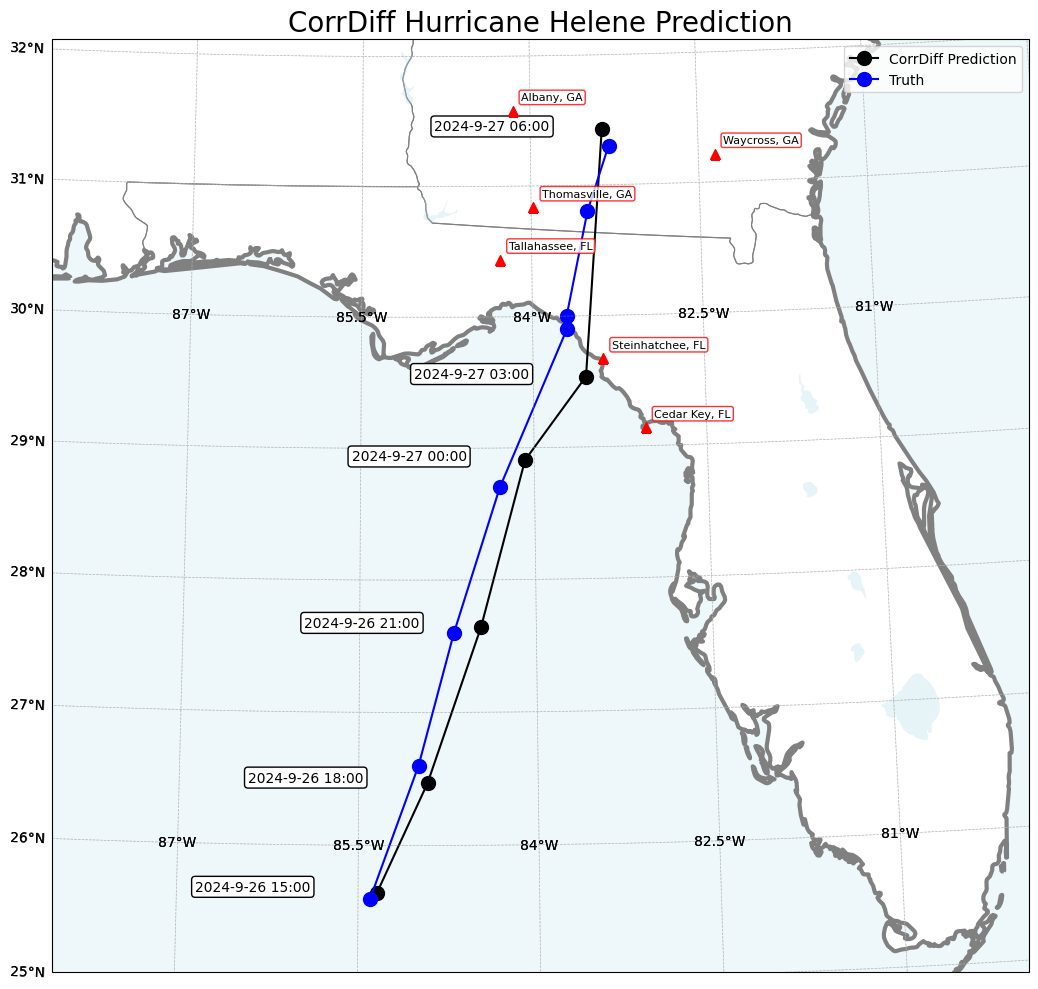

In [27]:

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=projection2)
 

# Make sure to plot AFTER setting up the map, and use transform
ax.coastlines(linewidth=3, color='gray')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='darkgray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, alpha=0.2, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False


# Plot the point with proper transform
ax.plot(Lon[0: -1], Lat[0 :-1], 'o-', color='black', markersize=10, 
        transform=ccrs.PlateCarree(), label = 'CorrDiff Prediction')
ax.plot(Helene_track_lon, Helene_track_lat, 'o-', color = 'blue', markersize = 10,
                transform=ccrs.PlateCarree(), label = 'Truth')


Time_Stamps = ['2024-9-26 15:00', '2024-9-26 18:00', '2024-9-26 21:00', '2024-9-27 00:00', '2024-9-27 03:00', '2024-9-27 06:00']
count = 0
for i in Time_Stamps:
    ax.text(Lon[count] - 1.5,
            Lat[count],
            i,
            transform=ccrs.PlateCarree(),
            fontsize = 10,
            bbox = dict(boxstyle = "round,pad = 0.25",
                       facecolor = "white",
                       edgecolor = "black"))
    count += 1

cities = {
    "Cedar Key, FL": (29.1383, -83.0316),
    "Steinhatchee, FL": (29.6716, -83.3876),
    "Tallahassee, FL": (30.4383, -84.2807),
    "Albany, GA": (31.5785, -84.1557),
    "Thomasville, GA": (30.8366, -83.9788),
    "Waycross, GA": (31.2136, -82.3540)

}

for name, (lat, lon) in cities.items():
    # plot city marker
    ax.scatter(lon, lat,
               s=50, marker='^',
               color='red',
               transform=ccrs.PlateCarree(),
               zorder=8)

    # add city label with box
    ax.text(lon + 0.08, lat + 0.08, name,
            fontsize=8,
            transform=ccrs.PlateCarree(),
            zorder=9,
            bbox=dict(boxstyle="round,pad=0.2",
                      facecolor="white",
                      edgecolor="red",
                      alpha=0.8))
  
ax.set_extent([la_lon[0] + 2, la_lon[1], la_lat[0], la_lat[1]], crs=pc)
ax.set_title('CorrDiff Hurricane Helene Prediction', fontsize = 20)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.legend()
plt.savefig('HurrHele_Prediction_track.png') 
plt.tight_layout()
plt.show()